Dentro de vs_release_16k.zip descomprimimos dos carpetas:  
- audio_16k  
- meta  

Nos servimos del módulo zipfile para descomprimir y adicionalmente del módulo concurrent para utilizar threads agilizando la descompresión.  
https://superfastpython.com/multithreaded-unzip-files/#Unzip_Files_Concurrently_with_Processes

In [1]:
import os
from zipfile import ZipFile

zip_file_name = "vs_release_16k.zip"
dirs_to_extract = ["audio_16k", "meta"]
output_dir = "data"

if not os.path.exists(output_dir):
    with ZipFile(zip_file_name, 'r') as zf:
        files_to_extract = [file for file in zf.namelist()
                            if any(file.startswith(dir) for dir in dirs_to_extract)]
        zf.extractall(path=output_dir, members=files_to_extract)

print(os.listdir(output_dir))

['meta', 'audio_16k']


Ahora pasamos los datos a numpy arrays para poder trabajar con ellos:

In [2]:
import os
import wave
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

def read_wav_file(wav_file):
    with wave.open(wav_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)
        wave_array = np.frombuffer(frames, dtype=np.int16)
        wave_name = os.path.basename(wav_file)
        wave_name = os.path.splitext(wave_name)[0]
    return wave_name, wave_array

base_dir = "data"
dir = "audio_16k"

audio_dir = os.path.join(base_dir, dir)
audios = os.listdir(audio_dir)
audio_paths = [os.path.join(audio_dir, file) for file in audios]

with ThreadPoolExecutor() as exe:
    results = list(exe.map(read_wav_file, audio_paths))

results[0:5]

[('f0788_0_sneeze', array([ 4, -1,  9, ..., -5, -4, -5], dtype=int16)),
 ('m0068_0_sneeze', array([-12, -22, -24, ..., -12, -11, -13], dtype=int16)),
 ('f0927_0_sniff', array([ 0,  0,  1, ...,  0, -1,  0], dtype=int16)),
 ('f0850_0_laughter',
  array([ -79, -125, -105, ...,   -4,   -6,  -10], dtype=int16)),
 ('m1749_0_sneeze', array([ 0,  0,  0, ...,  1,  0, -1], dtype=int16))]

Observación: Nuestros threads acceden a elementos distintos por tanto no hay problemas de race condition.

f0003_0_cough.wav  
f -> female  
(o -> old? check transcripted)  
cough -> one of the 6 labels  
0 -> index of that cough (individuals may have more than 1 cough registered)

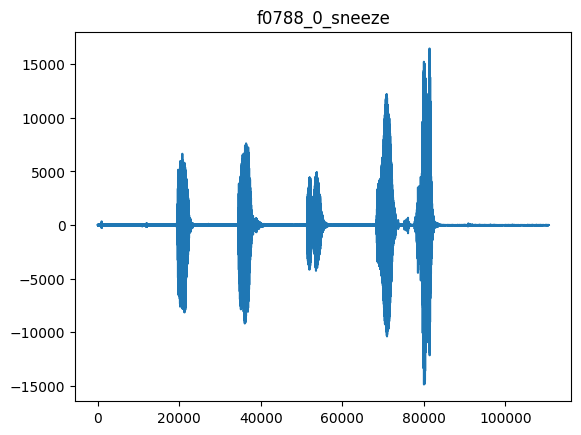

In [3]:
import matplotlib.pyplot as plt
name, arr = results[0]
plt.plot(arr)
plt.title(name)
plt.show()

In [4]:
import pandas as pd
df = pd.DataFrame(results, columns=['id', 'data'])
df.head()

,id,data
0,f0788_0_sneeze,"[4, -1, 9, -10, 2, 16, 14, 15, -5, 8, 18, 23, ..."
1,m0068_0_sneeze,"[-12, -22, -24, -37, -26, -24, -34, -40, -42, ..."
2,f0927_0_sniff,"[0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0..."
3,f0850_0_laughter,"[-79, -125, -105, -106, -84, -74, -56, -41, -1..."
4,m1749_0_sneeze,"[0, 0, 0, 0, 1, 1, 0, 0, -1, 1, 0, -2, -1, 0, ..."


In [6]:
import re

pattern = r'([mf])(\d+)_(\d+)_(\w+)'

def extract_info(string):
    match = re.match(pattern, string)
    if match:
        sex = match.group(1)
        id = match.group(2)
        index = match.group(3)
        class_name = match.group(4)
        return pd.Series([sex, id, index, class_name])
    else:
        return pd.Series([None, None, None, None])
df_std = df.copy()
df_std[['sex', 'id', 'index', 'class']] = df_std['id'].apply(extract_info)
df_std.head()

,id,data,sex,index,class
0,0788,"[4, -1, 9, -10, 2, 16, 14, 15, -5, 8, 18, 23, ...",f,0,sneeze
1,0068,"[-12, -22, -24, -37, -26, -24, -34, -40, -42, ...",m,0,sneeze
2,0927,"[0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0...",f,0,sniff
3,0850,"[-79, -125, -105, -106, -84, -74, -56, -41, -1...",f,0,laughter
4,1749,"[0, 0, 0, 0, 1, 1, 0, 0, -1, 1, 0, -2, -1, 0, ...",m,0,sneeze
